# ToMATo for protein conformation

## Import of libraries and helper functions 

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn import manifold
from tqdm import tqdm

In [7]:
# import functions from python files stored in utils directory 

import sys
sys.path.append('../src')
from helper_functions import *

## 1- Data loading and visualisation

### Data loading and conversion to usable format

In [1]:
xyz = open("..data/aladip/aladip_implicit.xyz", "r")
k=0
for line in xyz:
    if k<10:
        print('>>> ', line)
        k+=1
    else:
        break
xyz.close()

>>>  24.949 24.689 25.193

>>>  24.881 24.824 25.159

>>>  24.769 24.855 25.208

>>>  24.959 24.901 25.083

>>>  24.917 25.034 25.028

>>>  24.919 25.132 25.141

>>>  24.991 25.083 24.904

>>>  24.974 25.201 24.867

>>>  25.077 24.998 24.830

>>>  25.143 25.022 24.700



In [2]:
xyz = open("..data/aladip/dihedral.xyz", "r")
k=0
for line in xyz:
    if k<10:
        print('>>> ', line)
        k+=1
    else:
        break
xyz.close()

>>>    -2.7394562e+00   1.9710530e-01

>>>    -1.4092216e+00  -3.7683849e-02

>>>    -1.0991716e+00   1.5843425e-01

>>>    -2.6436599e+00  -6.8284164e-02

>>>    -1.2765906e+00  -2.6540122e-01

>>>    -2.2302756e+00   1.7024640e-02

>>>    -2.5553681e+00   2.2676463e-01

>>>    -1.7089955e+00  -7.4869730e-02

>>>    -1.9782164e+00  -1.7803117e-01

>>>    -1.4665155e+00  -2.8951271e-01



In [4]:
aladip_implicit = read_xyz("../data/aladip/aladip_implicit.xyz", 14207380, 3)

In [9]:
dihedral = read_xyz("../data/aladip/dihedral.xyz", 14207380, 2)

In [24]:
dihedral

array([[-2.7394562 ,  0.1971053 ],
       [-1.4092216 , -0.03768385],
       [-1.0991716 ,  0.15843425],
       ...,
       [-1.1673786 , -0.38899079],
       [-2.6664051 ,  0.45599431],
       [-2.4949599 , -0.60466692]])

### Visualisation

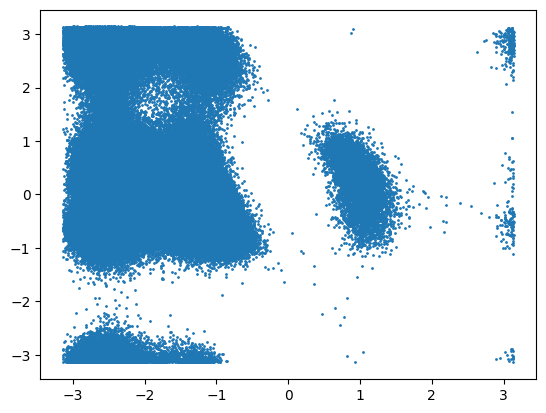

In [12]:
plt.scatter(dihedral[:,0], dihedral[:,1], s=1)
plt.show()

## 2- Compute RMSD distance matrix

### Helper functions

In [5]:
quaternion_rmsd(aladip_implicit[0:10],aladip_implicit[10:20])

0.07284970254320847

### Get subsample of the dataset

In [11]:
conformations = []
for k in range(int(len(aladip_implicit)/10)):
    conformations.append([aladip_implicit[k*10:(k+1)*10]])

In [12]:
len(conformations)

1420738

In [13]:
conform_sample = []
dihedral_sample = []
for k in range(len(conformations)):
    if k%400 == 0:
        conform_sample.append(conformations[k])
        dihedral_sample.append(dihedral[k])
        
dihedral_sample = np.array(dihedral_sample)

In [9]:
len(conform_sample)

3552

In [10]:
conform_sample[5][0]

array([[24.888, 24.699, 25.135],
       [24.965, 24.807, 25.063],
       [25.085, 24.797, 25.042],
       [24.89 , 24.915, 25.038],
       [24.925, 25.016, 24.95 ],
       [24.798, 25.078, 24.899],
       [25.009, 25.132, 25.012],
       [25.058, 25.222, 24.944],
       [25.023, 25.126, 25.149],
       [25.078, 25.235, 25.225]])

### Compute matrix

In [15]:
RMSD_m_sample = np.zeros((len(conform_sample), len(conform_sample)))
for k in tqdm(range(len(conform_sample))):
    for i in range(len(conform_sample)):
        RMSD_m_sample[k, i] = quaternion_rmsd(np.array(conform_sample[k][0]), np.array(conform_sample[i][0]))

#print(RMSD_m_sample)

100%|███████████████████████████████████████| 3552/3552 [26:55<00:00,  2.20it/s]


In [23]:
print(len(RMSD_m_sample))
print(len(RMSD_m_sample[0]))

3552
3552


In [29]:
## Save the matrix in a text file
np.savetxt('../data/RMSD_sample_matrix.txt', RMSD_m_sample)

In [16]:
# Read the matrix from the text file
RMSD_m_sample = np.loadtxt('../data/RMSD_sample_matrix.txt')

## 3- Produce embedding in 2 dimensions

### Apply MDS to produce 2D embedding of the RMSD matrix

In [25]:
mds_model = manifold.MDS(n_components = 2, random_state = 123,
    dissimilarity = 'precomputed')
mds_fit = mds_model.fit(RMSD_m_sample)  
mds_coords = mds_model.fit_transform(RMSD_m_sample) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


### Visualise

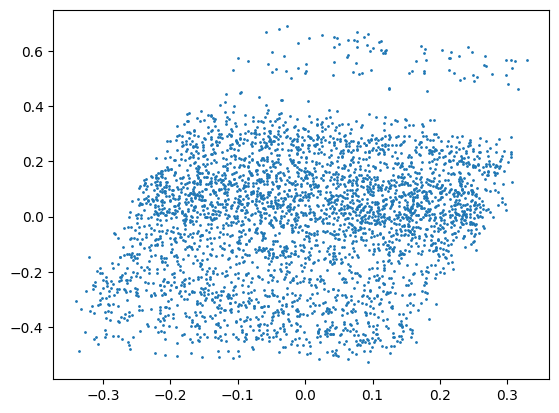

In [26]:
plt.scatter(mds_coords[:,0],mds_coords[:,1], s=1)
plt.show()

## 4- ToMATo

In [18]:
from gudhi.clustering.tomato import Tomato

### Influence of density 


 >>> Plot for DTM density


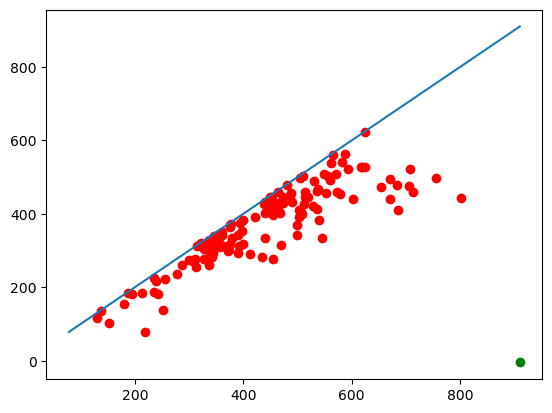


 >>> Plot for logDTM density


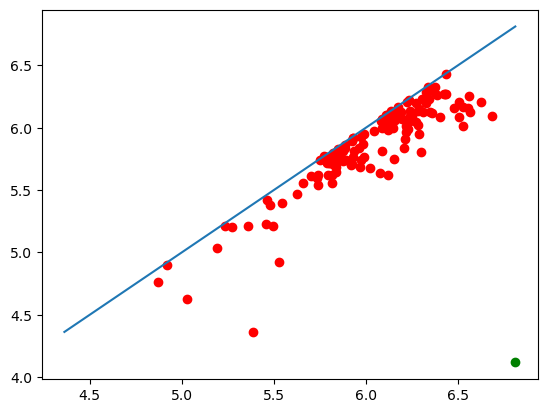

In [19]:
density_types = ['DTM', 'logDTM'] # We can't test KDE and logKDE density functions, because metric is "precomputed"
for density in density_types:
    t = Tomato(density_type=density, metric="precomputed", n_jobs=-1)
    t.fit(RMSD_m_sample)
    print(f"\n >>> Plot for {density} density")
    t.plot_diagram()

### Visualize the clustering 

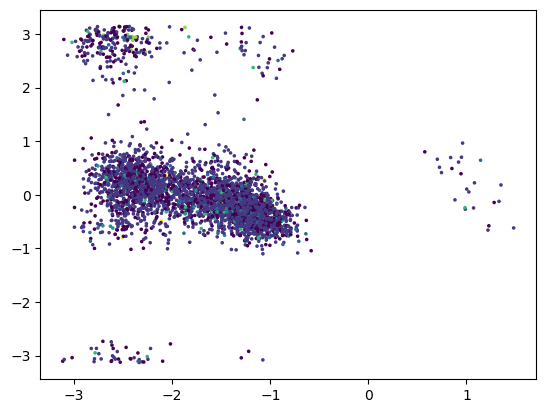

In [39]:
t.n_clusters_=7
plt.scatter(dihedral_sample[:,0],dihedral_sample[:,1],marker='.',s=10, c=t.labels_)
plt.show()